# Grouped Search for Device Comparisons

This notebook demonstrates PyMAUDE's grouped search functionality for comparing multiple device categories.


## What You'll Learn

1. Dict-based grouped search syntax
2. Working with the `search_group` column
3. Using helper functions with grouped results
4. Comparative analysis across device types
5. Handling overlapping results

## Setup

In [1]:
from pymaude import MaudeDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Create database and download data
db = MaudeDatabase('notebooks.db', verbose=True)
db.add_years('2020-2023', tables=['device', 'master'], download=True)
db.create_search_index()

print("Setup complete!")


Grouping years by file for optimization...

  Using cached device2020.zip
  Using cached device2021.zip
  Using cached device2022.zip
  Using cached device2023.zip
  Using cached mdrfoithru2025.zip

Processing data files...

device for year 2020 already loaded and unchanged, skipping

device for year 2021 already loaded and unchanged, skipping

device for year 2022 already loaded and unchanged, skipping

device for year 2023 already loaded and unchanged, skipping

master for years 2020-2023 already loaded and unchanged, skipping

Creating indexes...
debug: tables = []
debug: existing_tables = {'device', '_maude_load_metadata', 'master', 'text'}
debug: there is NOT a master table
debug: there is NOT a device table

Database update complete
Updating search index for 6,555,766 new device records...
  - Populating with concatenated values
  - Creating index on 8,900,872 rows
Search index updated in 292.5s
Setup complete!


## 1. Basic Grouped Search

Use a dictionary to search for multiple device categories at once. Each key becomes a group name in the results:

In [2]:
# Compare mechanical vs aspiration thrombectomy devices
results = db.search_by_device_names({
    'mechanical': [['argon', 'cleaner'], 'angiojet'],  # (argon AND cleaner) OR angiojet
    'aspiration': ['penumbra']                            # penumbra
})

print(f"Total events: {len(results)}")
print(f"\nGroups found: {results['search_group'].unique()}")
print(f"\nEvents by group:")
print(results['search_group'].value_counts())

Total events: 7124

Groups found: ['mechanical' 'aspiration']

Events by group:
search_group
aspiration    6537
mechanical     587
Name: count, dtype: int64


### The search_group Column

When you use dict input, the results include a `search_group` column tracking which group each event belongs to:

In [3]:
# View some results
print(results[['search_group', 'BRAND_NAME', 'GENERIC_NAME', 'DATE_RECEIVED']].head(10))

  search_group             BRAND_NAME                     GENERIC_NAME  \
0   mechanical    ANGIOJET ZELANTEDVT            CATHETER, EMBOLECTOMY   
1   mechanical     ANGIOJET SPIROFLEX            CATHETER, EMBOLECTOMY   
2   mechanical     ANGIOJET SPIROFLEX            CATHETER, EMBOLECTOMY   
3   mechanical    ANGIOJET ZELANTEDVT            CATHETER, EMBOLECTOMY   
4   mechanical    ANGIOJET ZELANTEDVT            CATHETER, EMBOLECTOMY   
5   mechanical   ANGIOJET ULTRA 5000A  CATHETER, CORONARY, ATHERECTOMY   
6   mechanical  ANGIOJET SOLENT DISTA            CATHETER, EMBOLECTOMY   
7   mechanical   ANGIOJET SOLENT OMNI            CATHETER, EMBOLECTOMY   
8   mechanical    ANGIOJET ZELANTEDVT            CATHETER, EMBOLECTOMY   
9   mechanical     ANGIOJET SPIROFLEX            CATHETER, EMBOLECTOMY   

         DATE_RECEIVED  
0  2020-01-02 00:00:00  
1  2020-01-02 00:00:00  
2  2020-01-02 00:00:00  
3  2020-01-03 00:00:00  
4  2020-01-03 00:00:00  
5  2020-01-10 00:00:00  
6  2020-01

## 2. Complex Group Criteria

Each group can have its own complex boolean logic:

In [4]:
# Compare different stent types
results = db.search_by_device_names({
    'coronary': [['coronary', 'stent']],                    # coronary AND stent
    'venous': ['venous stent', ['venous', 'stent']],        # "venous stent" OR (venous AND stent)
    'peripheral': [['peripheral', 'stent'], ['vascular stent']]  # (peripheral AND stent) OR "vascular stent"
}, start_date='2020-01-01')

print(f"Total stent events: {len(results)}")
print(f"\nBreakdown by stent type:")
counts = results['search_group'].value_counts()
for group, count in counts.items():
    pct = 100 * count / len(results)
    print(f"  {group}: {count} ({pct:.1f}%)")

Total stent events: 26827

Breakdown by stent type:
  coronary: 20392 (76.0%)
  peripheral: 5605 (20.9%)
  venous: 830 (3.1%)


/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 17 events previously matched to other groups were skipped from 'peripheral'
  warnings.warn(


## 3. Using Helper Functions with Grouped Results

Helper functions automatically use the `search_group` column for analysis:

### Trends Over Time

In [5]:
# Get thrombectomy device events
results = db.search_by_device_names({
    'stents': [['venous', 'stent']],
    'pacemakers': [['cardiac', 'pacemaker'], ['heart', 'pacemaker']]
}, start_date='2020-01-01')

# Get trends - automatically includes search_group breakdown
trends = db.get_trends_by_year(results)

print("Yearly trends by device type:")
print(trends)

Yearly trends by device type:
  search_group  year  event_count
0   pacemakers  2020          593
1   pacemakers  2021          880
2   pacemakers  2022          972
3   pacemakers  2023         1270
4       stents  2020          102
5       stents  2021          394
6       stents  2022          119
7       stents  2023          215


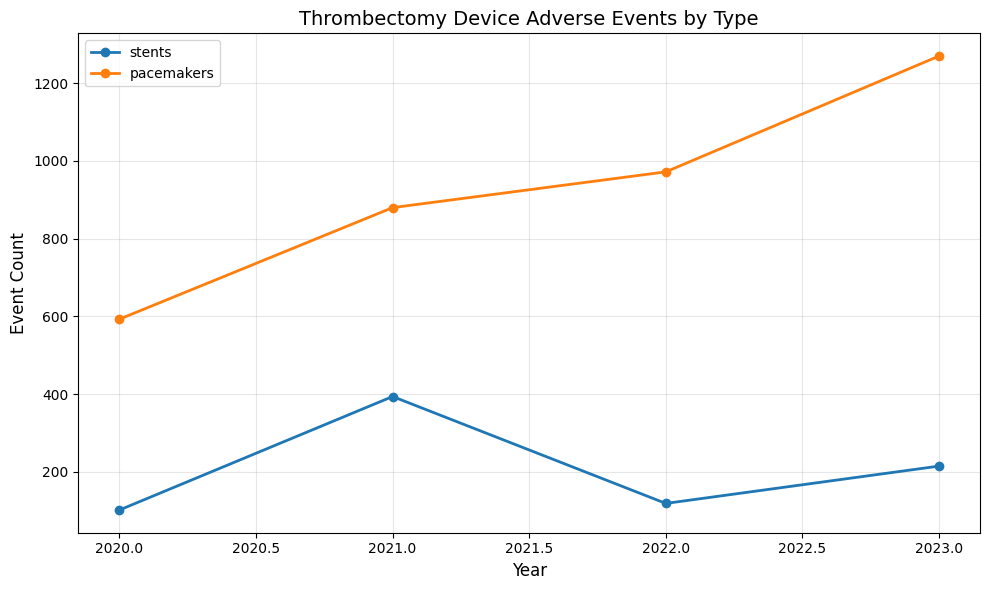

In [7]:
# Visualize trends
plt.figure(figsize=(10, 6))

for group in results['search_group'].unique():
    group_trends = trends[trends['search_group'] == group]
    plt.plot(group_trends['year'], group_trends['event_count'], marker='o', label=group, linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title('Thrombectomy Device Adverse Events by Type', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Summary Statistics

In [9]:
# Get summary by group (automatically uses search_group)
summary = db.summarize_by_brand(results)

print("Event counts by group:")
print(summary['counts'])

print("\nEvent type breakdown:")
print(summary['event_types'])

Event counts by group:
{'pacemakers': 3715, 'stents': 830}

Event type breakdown:
EVENT_TYPE     D    IN     M
search_group                
pacemakers    55  2178  1482
stents         3   271   556


### Event Type Comparison

In [10]:
# Compare event type distributions across groups
comparison = db.event_type_comparison(results)

print("Event type comparison:")
print(comparison['summary'])

print("\nStatistical test:")
print(comparison['chi2_test'])

Event type comparison:
Event Type Comparison by search_group
Chi-square: 202.70 (p=0.0000)

pacemakers: 1.5% deaths, 58.6% injuries, 39.9% malfunctions
stents: 0.4% deaths, 32.7% injuries, 67.0% malfunctions

Statistical test:
{'chi2_statistic': 202.69563111834492, 'p_value': 9.665024287202268e-45, 'dof': 2, 'expected_frequencies': event_type    has_death   has_injury  has_malfunction
search_group                                         
pacemakers    47.408141  2001.767877      1665.823982
stents        10.591859   447.232123       372.176018, 'significant': np.True_}


## 4. Analyzing Individual Groups

Filter to a single group for detailed analysis:

In [11]:
# Get grouped search results
results = db.search_by_device_names({
    'pacemaker': 'pacemaker',
    'defibrillator': 'defibrillator',
    'icd': ['icd', 'implantable cardioverter']
})

# Filter to pacemaker group only
pacemaker_only = results[results['search_group'] == 'pacemaker']

print(f"Pacemaker events: {len(pacemaker_only)}")
print(f"\nTop pacemaker brands:")
print(pacemaker_only['BRAND_NAME'].value_counts().head())

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 13811 events previously matched to other groups were skipped from 'defibrillator'
  warnings.warn(
/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 114394 events previously matched to other groups were skipped from 'icd'
  warnings.warn(


Pacemaker events: 234043

Top pacemaker brands:
BRAND_NAME
CAPSUREFIX NOVUS LEAD MRI SURESCAN    54544
TENDRIL STS                           18988
ASSURITY MRI                          11778
CAPSUREFIX NOVUS MRI SURESCAN          9382
R SERIES DEFIBRILLATOR                 6604
Name: count, dtype: int64


In [12]:
# Get trends for single group
pacemaker_trends = db.get_trends_by_year(pacemaker_only)

print("Pacemaker trends:")
print(pacemaker_trends)

# Note: search_group column may still be present if it was in the original DataFrame

Pacemaker trends:
  search_group  year  event_count
0    pacemaker  2020        51408
1    pacemaker  2021        53260
2    pacemaker  2022        58272
3    pacemaker  2023        71103


## 5. Date Filtering with Groups

Date filters apply to all groups:

In [13]:
# Compare recent events only
recent = db.search_by_device_names(
    {
        'insulin_pump': ['insulin pump', ['insulin', 'pump']],
        'cgm': ['continuous glucose', 'cgm', ['glucose', 'monitor']],
        'blood_glucose': ['glucometer', 'blood glucose meter']
    },
    start_date='2022-01-01',
    end_date='2023-12-31'
)

print(f"Diabetes device events (2022-2023): {len(recent)}")
print(f"\nBreakdown:")
print(recent['search_group'].value_counts())

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 11 events previously matched to other groups were skipped from 'cgm'
  warnings.warn(
/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 92 events previously matched to other groups were skipped from 'blood_glucose'
  warnings.warn(


Diabetes device events (2022-2023): 1252212

Breakdown:
search_group
insulin_pump     634502
cgm              617371
blood_glucose       339
Name: count, dtype: int64


## 6. Understanding Overlap Handling

Events matching multiple groups only appear in the FIRST matching group (based on dict order):

In [14]:
# Example with potential overlap
results = db.search_by_device_names({
    'all_catheters': 'catheter',           # Broad search
    'specific_type': 'cardiac catheter'    # More specific - but will miss events already in first group
})

# Events matching "cardiac catheter" appear ONLY in 'all_catheters' (first group)
# Warnings are issued during search

print(f"All catheters: {(results['search_group'] == 'all_catheters').sum()}")
print(f"Specific type: {(results['search_group'] == 'specific_type').sum()}")
print("\nNote: 'specific_type' count may be lower due to overlap with 'all_catheters'")

All catheters: 179588
Specific type: 0

Note: 'specific_type' count may be lower due to overlap with 'all_catheters'


/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 40 events previously matched to other groups were skipped from 'specific_type'
  warnings.warn(


### Best Practice: Order Groups from Specific to General

In [15]:
# Better approach - specific groups first
results = db.search_by_device_names({
    'cardiac_catheter': ['cardiac catheter', ['cardiac', 'catheter']],  # Specific first
    'other_catheters': 'catheter'                                        # General last
})

print(f"Cardiac catheters: {(results['search_group'] == 'cardiac_catheter').sum()}")
print(f"Other catheters: {(results['search_group'] == 'other_catheters').sum()}")

Cardiac catheters: 10834
Other catheters: 168754


/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1940: UserWarning: 10834 events previously matched to other groups were skipped from 'other_catheters'
  warnings.warn(


## 7. Real-World Example: Venous Thromboembolism Device Comparison

In [16]:
# Compare different VTE treatment modalities
vte_devices = db.search_by_device_names(
    {
        'mechanical_thrombectomy': [
            ['argon', 'cleaner'], 
            ['cleaner', 'xt'],
            'angiojet',
            ['angiojet', 'zelante']
        ],
        'aspiration_thrombectomy': [
            ['penumbra', 'indigo'],
            ['penumbra', 'lightning'],
            'indigo'
        ],
        'retrieval_system': [
            'flowtriever',
            ['inari', 'flowtriever']
        ],
        'venous_stent': [
            'venovo',
            ['venous', 'stent'],
            'venous stent'
        ]
    },
    start_date='2019-01-01',
    end_date='2023-12-31'
)

print(f"Total VTE device events (2019-2023): {len(vte_devices)}")
print(f"\nEvents by modality:")
modality_counts = vte_devices['search_group'].value_counts().sort_values(ascending=False)
for modality, count in modality_counts.items():
    pct = 100 * count / len(vte_devices)
    print(f"  {modality}: {count:,} ({pct:.1f}%)")

Total VTE device events (2019-2023): 2947

Events by modality:
  aspiration_thrombectomy: 1,517 (51.5%)
  venous_stent: 834 (28.3%)
  mechanical_thrombectomy: 587 (19.9%)
  retrieval_system: 9 (0.3%)


In [17]:
# Compare event types across modalities
comparison = db.event_type_comparison(vte_devices)

print("Event type distribution by modality:")
print(comparison['summary'])

if comparison['chi2_test']['p_value'] < 0.05:
    print(f"\n✓ Statistically significant difference (p={comparison['chi2_test']['p_value']:.4f})")
else:
    print(f"\n✗ No significant difference (p={comparison['chi2_test']['p_value']:.4f})")

Event type distribution by modality:
Event Type Comparison by search_group
Chi-square: 333.84 (p=0.0000)

aspiration_thrombectomy: 2.0% deaths, 7.3% injuries, 90.7% malfunctions
mechanical_thrombectomy: 1.4% deaths, 9.7% injuries, 88.8% malfunctions
retrieval_system: 22.2% deaths, 55.6% injuries, 22.2% malfunctions
venous_stent: 0.4% deaths, 32.7% injuries, 66.9% malfunctions

✓ Statistically significant difference (p=0.0000)


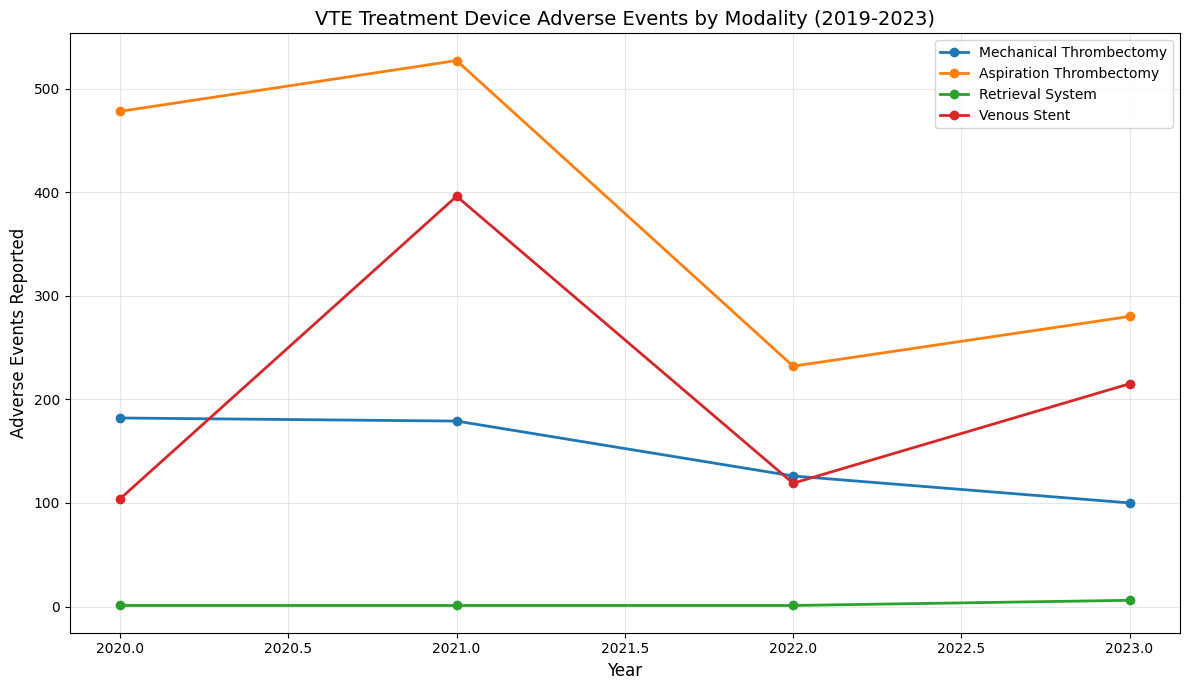

In [18]:
# Visualize trends
trends = db.get_trends_by_year(vte_devices)

plt.figure(figsize=(12, 7))

for modality in vte_devices['search_group'].unique():
    modality_trends = trends[trends['search_group'] == modality]
    plt.plot(modality_trends['year'], modality_trends['event_count'], 
             marker='o', label=modality.replace('_', ' ').title(), linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Adverse Events Reported', fontsize=12)
plt.title('VTE Treatment Device Adverse Events by Modality (2019-2023)', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Exporting Grouped Results

In [19]:
# Export results with search_group column
vte_devices.to_csv('vte_devices_by_modality.csv', index=False)

print(f"Exported {len(vte_devices)} records to vte_devices_by_modality.csv")
print(f"Includes search_group column for filtering in Excel/R/other tools")

Exported 2947 records to vte_devices_by_modality.csv
Includes search_group column for filtering in Excel/R/other tools


## Cleanup

In [20]:
db.close()
print("Database closed.")

Database closed.


## Summary

Key takeaways:

1. **Dict syntax**: `db.search_by_device_names({'group1': criteria1, 'group2': criteria2})`
2. **Results include `search_group` column** for tracking group membership
3. **Helper functions automatically use `search_group`** for grouping
4. **First-match-wins**: Events only appear in first matching group
5. **Order matters**: Put specific groups before general ones
6. **Date filters apply to all groups**

## Next Steps

- **03_exact_queries.ipynb** - Precise field-based queries
- **04_analysis_helpers.ipynb** - Comprehensive helper function guide
- **05_advanced_workflows.ipynb** - Complex real-world workflows